In [1]:
from testproblems import generate_random_prob
from representations import bipartite_repr
from inputresolver import resolve,invert_edges,getallvars,direct_eqs
from datastructures.polycasebuilder import eqv_to_edges_tree
from datastructures.graphutils import flat_graph_formulation, draw_graph_graphical_props, VAR, COMP, SOLVER, Node, namefromid, copy_dicts
from datastructures.operators import sort_scc, reorder_merge_solve

In [2]:
import seaborn as sns
import numpy as np
sns.set_theme(style="darkgrid")

In [3]:
from datastructures.tearing import min_max_scc, min_max_scc2, dir_graph, var_matched_cons_reversed, assignminscc2
from datastructures.rendering import render_incidence, incidence_artifacts
from datastructures.graphutils import all_edges, edges_to_Ein_Eout
from collections import OrderedDict
import matplotlib.pyplot as plt
from itertools import chain, islice
import networkx as nx

In [4]:
from ipywidgets import IntProgress
from IPython.display import display

In [5]:
from datastructures.graphutils import edges_E

In [6]:
from itertools import combinations, product
import pandas as pd

In [7]:
pd.options.mode.chained_assignment = None

In [32]:
data = []
#10,15,20,25,30,
for m,ncoeff,sparsity,seed in product((100,),(0.1,0.2,0.5),(0.5,1.,1.5),range(10)):
    n=m+int(ncoeff*m)
    eq_incidence, var_incidence, outset = generate_random_prob(m, n, seed, sparsity)
    edges_varonleft = edges_E(eq_incidence)
    eqnidxs = eq_incidence.keys()
    varidxs = var_incidence.keys()
    D = nx.DiGraph(dir_graph(edges_varonleft, eqnidxs, outset.items()))
    max_scc = max(len(elt) for elt in nx.strongly_connected_components(D))//2
    data.append([m, ncoeff, n, sparsity, seed, max_scc])

In [33]:
df2 = pd.DataFrame(data, columns=["m","ncoeff", "n","sparsity","seed", "maxscc"])

In [34]:
df = pd.concat([df,df2], ignore_index=True)

In [24]:
df["minscc"] = 0
df["time"] = None

In [23]:
df = pd.read_csv('minscc_experiments.csv', index_col=0)

In [40]:
df.iloc[60:90]

,m,ncoeff,n,sparsity,seed,maxscc,minscc,time
60,10,0.5,15,0.5,0,2,2.0,0.006186
61,10,0.5,15,0.5,1,0,0.0,0.000925
62,10,0.5,15,0.5,2,0,0.0,0.001249
63,10,0.5,15,0.5,3,2,0.0,0.004002
64,10,0.5,15,0.5,4,0,0.0,0.000912
65,10,0.5,15,0.5,5,0,0.0,0.001999
66,10,0.5,15,0.5,6,0,0.0,0.000999
67,10,0.5,15,0.5,7,0,0.0,0.000998
68,10,0.5,15,0.5,8,0,0.0,0.001232
69,10,0.5,15,0.5,9,2,0.0,0.000458


In [36]:
max_count = len(df)
f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f)
iter_cycles = 630#len(data) 
for idx in islice(df.index,iter_cycles):
    row = df.iloc[idx]
    if pd.isna(row.time):
        m,n,seed,sparsity = [df.at[idx,colname] for colname in ['m','n','seed','sparsity']] # to keep datatype
        eq_incidence, var_incidence, outset = generate_random_prob(m,n,int(seed),sparsity)
        edges_varonleft = edges_E(eq_incidence)
        eqnidxs = eq_incidence.keys()
        varidxs = var_incidence.keys()
        xsol, m = min_max_scc2(edges_varonleft, varidxs, eqnidxs, timeout=100)
        if xsol:
            minssc = int(m.getObjective().getValue())//2-1
            df["minscc"][idx] = max(minssc,0)
        else:
            df["minscc"][idx] = 999
        df["time"][idx] = m.Runtime
        df.to_csv('minscc_experiments.csv')
    f.value += 1

IntProgress(value=0, max=630)

In [41]:
sparseL1 = df.iloc[0:200][df.iloc[0:200]['sparsity']==0.5]

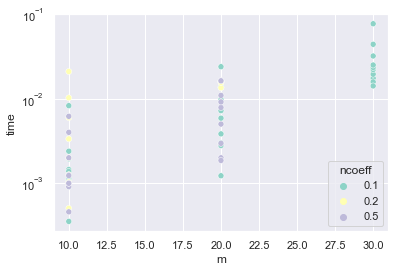

In [42]:
#df[['ncoeff', 'sparsity']].apply(tuple, axis=1)
g = sns.pointplot(data=sparseL1, x="m", y="time", hue="ncoeff", palette="Set3", capsize=.2)
g.set_yscale("log")

In [8]:
#def full_run(m, ncoeff, sparsity, seed):
m=30
ncoeff=0.1
sparsity=1.5
seed=7
n=m+int(ncoeff*m)
eq_incidence, var_incidence, outset = generate_random_prob(m, n, seed, sparsity)
eqnidxs = eq_incidence.keys()
varidxs = var_incidence.keys()
edges_varonleft = edges_E(eq_incidence)

In [ ]:
xsol, m = min_max_scc2(edges_varonleft, varidxs, eqnidxs, timeout=1)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


# Parameters

In [3]:
n_eqs = 10
n_vars = 13
seed = 10#8 is triang#seed 10 is nice 42
sparsity = 1.7#0.87#0.8 1.1 #1.7 1.3

# Setup

In [4]:
nodetyperepr = {VAR: 'x_{{{}}}', COMP: 'f_{{{}}}', SOLVER: '{}'}

In [5]:
namingfunc = namefromid(nodetyperepr)

# Original indexation

In [6]:
eqv, varinc, output_idx = generate_random_prob(n_eqs, n_vars, seed, sparsity)
_, edges_original = bipartite_repr(eqv)
eqs = direct_eqs(eqv, output_idx)
varidxs = getallvars(eqs, sympy=False)
eqnidxs = set(eqs.keys())

# Pretty indexation

In [7]:
output_reidx = {key:var-n_eqs for key,var in output_idx.items()}
edges, tree = eqv_to_edges_tree(eqv, output_reidx, n_eqs)

# Original

In [8]:
G = flat_graph_formulation(*edges)
merge_order = sort_scc(G)
maxscc = max([len(elt) for elt in merge_order])

# Optimal scc

In [14]:
import networkx as nx
import gurobipy as gp
from gurobipy import GRB

In [34]:
def get_scc(xval, xref, rightset):
    edges_left_right = xref.keys()
    selected = tuple((right, left) for left, right in edges_left_right if xval[left, right] > 0.5)
    D = nx.DiGraph(dir_graph(edges_left_right, rightset, selected))
    S = nx.strongly_connected_components(D)
    scc = [elt for elt in S if len(elt)>1]
    return scc, D

def assignminscc(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        x_sol = model.cbGetSolution(model._x)
        allscc, _ = get_scc(x_sol, model._x, model._rightset)
        print(allscc)
        for idx, scc in enumerate(allscc):
            g = model._G.subgraph(scc)
            model.cbLazy(gp.quicksum(model._x[edge] if edge in model._x else model._x[edge[::-1]] for edge in g.edges())<=model._c)

In [39]:
def var_matched_cons_reversed(x, i, not_input=None, not_output=None):
    not_input = [] if not_input == None else not_input
    not_output = [] if not_output == None else not_output
    eqconstant = 1 if i not in not_output else 0
    if i in not_input:
        return x.sum(i, '*') == eqconstant
    else:
        return x.sum(i, '*') <= eqconstant

In [60]:
def min_max_scc2(edges_left_right, leftset, rightset, not_input=None, not_output=None):
    G = nx.Graph(edges_left_right)
    m = gp.Model('cycles')
    m.setParam('OutputFlag', False )
    m.setParam('TimeLimit', 10)
    x = m.addVars(edges_left_right, name="assign", vtype=GRB.BINARY)
    c = m.addVar(lb=0.0)
    # A variable node can have maximum one ouput edge (possibly of none)
    m.addConstrs((x.sum('*',i) == 1 for i in rightset), name='equations') #needs to be equality
    # An equation node shall have one output edge unless part of elimination set
    m.addConstrs((var_matched_cons_reversed(x,i, not_input, not_output) for i in leftset), name='variables')
    m.setObjective(c, GRB.MINIMIZE)
    m._rightset = rightset
    m._G = G
    m._x = x
    m._c = c
    m.Params.lazyConstraints = 1
    m.optimize(assignminscc)
    return m.getAttr('x', x), m

In [61]:
#edges_left_right = list(dir_graph(edges_original, eqnidxs, {})) # not needed, since order is correct already

In [10]:
xsol, m = min_max_scc2(edges_original, varidxs, eqnidxs)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [11]:
m.getObjective().getValue()

6.0

In [15]:
selected = tuple((right, left) for left, right in edges_original if xsol[left, right] > 0.5)

In [16]:
D = nx.DiGraph(dir_graph(edges_original, eqnidxs, selected))
minassign_order = sort_scc(D, lambda x: x in eqnidxs)

In [17]:
minassign_order

[{3}, {9}, {7}, {2, 4}, {0}, {1}, {6}, {8}, {5}]

In [9]:
optim_edges = list(dir_graph(edges_original, varidxs))

In [10]:
maxl, xsol, m = min_max_scc(optim_edges, varidxs, eqnidxs)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [11]:
maxl

2.0

In [12]:
selected = dict((left, right-n_eqs) for left, right in optim_edges if xsol[left, right] > 0.5)

In [13]:
selected

{0: 4, 1: 0, 2: 8, 3: 5, 4: 1, 5: 6, 6: 3, 7: 11, 8: 10, 9: 7}

In [14]:
Ein, Eout, Rin = copy_dicts(edges)
_, Stree, Vtree = copy_dicts(tree)
Eout_minassign = Eout.copy()
Ein_minassign = Ein.copy()
for comp in Eout.keys():
    if comp in selected:
        var = selected[comp]
        Eout_minassign[comp] = (var,)
        Ein_minassign[comp] = tuple(elt for elt in chain(Ein[comp],Eout[comp]) if elt!=var)
    else:
        old_out_var = Eout[comp][0]
        Eout_minassign[comp] = (None,)
        Ein_minassign[comp] = tuple(elt for elt in chain(Ein[comp],Eout[comp]))

In [15]:
nodetyperepr = {VAR: 'x_{{{}}}', COMP: 'f_{{{}}}', SOLVER: '{}'}
edges_minassign = Ein_minassign, Eout_minassign, dict()
G2 = flat_graph_formulation(*edges_minassign, nodetyperepr=nodetyperepr)

In [16]:
minassign_order = sort_scc(G2)

In [17]:
minassign_order

[{f_{3}},
 {f_{9}},
 {f_{7}},
 {f_{2}, f_{4}},
 {f_{0}},
 {f_{1}},
 {f_{6}},
 {f_{8}},
 {f_{5}}]

In [18]:
nedges, ntree = reorder_merge_solve(edges_minassign, tree, minassign_order, 1)

In [19]:
#Ftree_mina = OrderedDict([(elt.name,'solver') for comp in minassign_order for elt in comp])

In [20]:
ntree

(OrderedDict([(3, 1),
              (9, 1),
              (7, 1),
              (2, 2),
              (4, 2),
              (0, 1),
              (1, 1),
              (6, 1),
              (8, 1),
              (5, 1)]),
 {2: 1},
 {8: 2, 1: 2})

## Visualize

In [42]:
sequence, permutation, Ein, Eout, solver_iterator = incidence_artifacts(nedges, ntree, True)

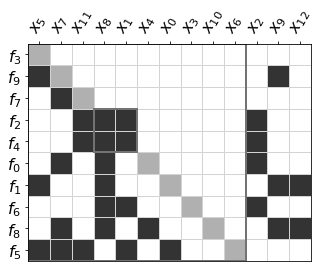

In [21]:
_, ax = render_incidence(nedges, ntree, namingfunc, displaysolver=True)
plt.sca(ax)
plt.savefig(r'minscc_10x13.png', dpi=300, bbox_inches='tight')